# DGGS for Mapping Calgary's Inequality

H3 is a geospatial indexing system using a hexagonal grid that can be (approximately) subdivided into finer and finer hexagonal grids. One of the applications of hexagons is to be able to combine different datasets with different geographic shapes and forms, to a common reference system. This way the data is ready for analysis.

Through this notebook we are going to use the open-sourced [H3 DGGS library](https://h3geo.org/) and its [Python bindings](https://github.com/uber/h3-py), along with the [ArcGIS Python API](https://developers.arcgis.com/python/), to convert Geospatial data into a DGGS system and publish it to our ArcGIS online account. In order to read, interact, and write spatial data from and to our ArcGIS online account, we are going to use the [Spatially Enabled Dataframe object](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/) from the ArcGIS Python API.

The notebook is structured into three sections: 
- The [first section](#DGGS-Hexagons-Generation) generates the DGGS hexagons for multiple resolutions from both polygons and raster input data.
- The [second section]() publishes the hexagons generated datasets into an ArcGIS online account.
- The [third section](#Introduction-to-Spatially-Enabled-Dataframes) presents an appendix introduction to Spatially Enabled Dataframes, a class from the ArcGIS Python API that is used within this notebook.

## DGGS Hexagons Generation

We are going to generate DGGS hexagons for multiple resolutions from the following input data:
- Ward Polygons containing attributes for each ward.
- Raster input data that contains the distances to different public facilities in each pixel.

We are going to use [Geopandas](https://geopandas.org/docs/user_guide/io.html) and [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) for geospatial data and geometry manipulation, [matplotlib](https://matplotlib.org/) for plotting, and the [H3 Python bindings](https://github.com/uber/h3-py) for the DGGS generation.

To map this data into a DGGS, we need to define a list of resolutions to generate a layer of hexagons per resolution level. We define levels 7 to 10. You may change this values if you want to see different results.

In [1]:
resolutions=[7,8,9,10]

Now were are going to define a set of functions to perform the Hexagons generation.

###### Helper function: plot

This function will plot a geodataframe based on a metric column and lat and long values.

In [2]:
#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

###### calc_hex_pol function

The calculate hexagons function will generate an hexagon Geodataframe from an input polygon geodataframe and a specific resolution level. It will then intersect the centroid of each hexagon with the polygons geodataframe to add the polygons attributes to the hexagons geodataframe

In [3]:
import geopandas
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import matplotlib.pyplot as plt
import h3

def calc_hex_pol(res,gdf):

    # Unify the polygons
    union_poly = cascaded_union(gdf.geometry)
    
    # Find the hexs within the ward boundaries using PolyFill
    hex_list=[]

    temp  = mapping(union_poly)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,res))

    # create hex dataframe
    hex_col = 'hex{}'.format(res)
    dfh = pd.DataFrame(hex_list,columns=[hex_col])
    print('Sanity Check\number of hexagons:', len(hex_list))
    print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

    # add lat & lng of center of hex 
    dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    
    # create Point object based on hex latlng
    gdf2 = geopandas.GeoDataFrame(
        dfh, geometry=geopandas.points_from_xy(dfh.lng, dfh.lat), crs="EPSG:4326")

    # Intersect Hex Point with Polygon to add the polygons attributes to the hex geodataframe
    df_ct = geopandas.tools.sjoin(gdf, gdf2, how="inner")
    
    #Assigns resolution attribute to the dataframe
    df_ct.attrs['resolution'] = res
    
    return df_ct

###### calc_hex_raster function

The calculate raster function will generate an hexagon Geodataframe from an input XYZ csv file representing a raster dataset with lat, long and z value (distances in this case). It will then calculate the average distance value per hexagon, by intersecting each hexagon with the input data. 

In [4]:
import geopandas
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import matplotlib.pyplot as plt
import h3

def calc_hex_raster(res,df,col):

    hex_col = 'hex'+str(res)

    # find hexs containing the points
    df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,res),1)
    
    # calculate elevation average per hex
    df_dem = df.groupby(hex_col)[col].mean().to_frame(col).reset_index()
    
    print('Sanity Check\nnumber of hexagons:', len(df_dem))
    print('number of duplicates:', len(df_dem) - len(df_dem.drop_duplicates()))

    #find center of hex for visualization
    df_dem['lat'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    df_dem['lng'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    
    #Assigns resolution attribute to the dataframe
    df_dem.attrs['resolution'] = res
    
    return df_dem

### Polygons to Hexagons

We are going to first inport the ward polygons Shapefile using the Geopandas [read_file](https://geopandas.org/docs/user_guide/io.html) function. This will generate a GeoDataFrame from the file.

In [5]:
from geopandas import read_file 

# Define the URL
data = "./data/vector/Census_by_ward_final.shp"

# Read file from URL
polGDF = read_file(data)

We will use the previosly defined calc_hex_pol function, and apply this function for every resolution defined into the resoltions array. The results will be stored into a list of hexagons GDFs. The function takes as input the resolution level and the polygons GeoDataFrame.

In [6]:
import pandas as pd

polGDFs=[]

#Loop through resolutions
for res in resolutions:
    #Calculate hexagons gdf and append to list
    tmpDF=calc_hex_pol(res,polGDF)
    polGDFs.append(tmpDF)

Sanity Check
umber of hexagons: 172
number of duplicates: 0
Sanity Check
umber of hexagons: 1202
number of duplicates: 0
Sanity Check
umber of hexagons: 8417
number of duplicates: 0
Sanity Check
umber of hexagons: 58899
number of duplicates: 0


We can check the data generated at resolution 7.

In [7]:
print(polGDFs[0].head())

      Ward  Resident     Male   Female  Dwelling  Household  Employed  \
0  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
0  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
0  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
0  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
0  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   

   Pre_school  Ownership  Age_0_4  ...      Top2_Count  Top3_Count  \
0        5902    22800.0     4887  ...  United Kingdom       China   
0        5902    22800.0     4887  ...  United Kingdom       China   
0        5902    22800.0     4887  ...  United Kingdom       China   
0        5902    22800.0     4887  ...  United Kingdom       China   
0        5902    22800.0     4887  ...  United Kingdom       China   

      Top4_Count  Top5_Count  Avg_income  \
0  United States       India     73171.8   
0  United States       India     73171.8   
0  Unite

### Raster to Hexagons

We will use the previosly defined calc_hex_raster function, and apply this function for every resolution defined into the resoltions array. Note that we are looping through the data/raster folder which contains all the XYZ csv files related to distances to public facilities:
- Public art
- Public libraries
- Playgrounds
- Recreation facilities
- Public schools

There is an additional step to do compared to the Polygon-to-Hexagon section. Within the files loop, we will merge all the files into one GeoDataFrame per resolution, since the hexagons generated are the same, only the distance attribute is different. The results will be stored into a list of hexagons GDFs.

In [8]:
import os
import glob

dictdems=[]
distancesGDF=[]

#Loop through resolutions
for i in range(len(resolutions)):
    fileN=0
    for filepath in glob.glob(os.path.join('./data/raster/', '*.csv')):
        
        #Define column names
        col=filepath.split("/")[-1].split(".")[0]
        
        print(f"Calculating file {col} at {resolutions[i]} resolution")
        
        # read xyz points
        df = pd.read_csv(filepath,sep=',',header=1,names=['lng','lat',col])
        
        #Merge files based on hexagon column
        if(fileN==0):
            dfu=calc_hex_raster(resolutions[i],df,col)
        else:
            dfu = dfu.merge(calc_hex_raster(resolutions[i],df,col))
            
        fileN += 1 
                            
    dfu.attrs['resolution'] = resolutions[i]
    distancesGDF.append(dfu)

Calculating file raster\Art_dis at 7 resolution
Sanity Check
number of hexagons: 213
number of duplicates: 0
Calculating file raster\Library_dis at 7 resolution
Sanity Check
number of hexagons: 213
number of duplicates: 0
Calculating file raster\Playground_dis at 7 resolution
Sanity Check
number of hexagons: 213
number of duplicates: 0
Calculating file raster\Recreation_dis at 7 resolution
Sanity Check
number of hexagons: 213
number of duplicates: 0
Calculating file raster\School_dis at 7 resolution
Sanity Check
number of hexagons: 213
number of duplicates: 0
Calculating file raster\Art_dis at 8 resolution
Sanity Check
number of hexagons: 1318
number of duplicates: 0
Calculating file raster\Library_dis at 8 resolution
Sanity Check
number of hexagons: 1318
number of duplicates: 0
Calculating file raster\Playground_dis at 8 resolution
Sanity Check
number of hexagons: 1318
number of duplicates: 0
Calculating file raster\Recreation_dis at 8 resolution
Sanity Check
number of hexagons: 1318


We can check part of the data generated at resolution 7:

In [9]:
print(distancesGDF[0].head())

              hex7  raster\Art_dis        lat         lng  raster\Library_dis  \
0  8712c1a69ffffff     4876.859160  51.131200 -114.312741         7743.666096   
1  8712cc890ffffff     4132.135802  50.907825 -113.857079        13354.244019   
2  8712cc892ffffff     4693.626022  50.896063 -113.883948        12602.275919   
3  8712cc893ffffff     6129.301989  50.886213 -113.852780        14044.195891   
4  8712cc894ffffff     2814.042813  50.929440 -113.861383        12235.133755   

   raster\Playground_dis  raster\Recreation_dis  raster\School_dis  
0            3373.987229            5159.788677        3735.997552  
1            3367.041326            6039.990168        4185.048080  
2            1859.501760            4753.047267        2965.834513  
3            3147.556250            5810.862536        4551.489622  
4            2870.303079            5528.644850        4353.959951  


### Merging Raster and Polygons data

We have now two list of GeoDataFrames that contains a GeoDataFrame per DGGS resolution.
- polGDFs: list of polygons GDFs
- distancesGDF: list of distances GDFs

We need to perform a spatial merge between each resolution, to end up with obe only set of hexagons per resolution. This is because the spatial extent of the raster data is different from the polygons, therefore the Hexagons generated were different. We also need the attribute data combined in the resulting hexagon layer per resolution.

In [10]:
mergedDFs=[]
for i in range(len(resolutions)):
    mergeDF = polGDFs[i].merge(distancesGDF[i])
    mergeDF.attrs['resolution'] = resolutions[i]
    mergedDFs.append(mergeDF)

We can check resulting data at resolution 7.

In [11]:
print(mergedDFs[0].head())

      Ward  Resident     Male   Female  Dwelling  Household  Employed  \
0  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
1  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
2  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
3  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
4  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   

   Pre_school  Ownership  Age_0_4  ...  \
0        5902    22800.0     4887  ...   
1        5902    22800.0     4887  ...   
2        5902    22800.0     4887  ...   
3        5902    22800.0     4887  ...   
4        5902    22800.0     4887  ...   

                                            geometry  index_right  \
0  POLYGON ((-114.11815 51.02390, -114.11791 51.0...           17   
1  POLYGON ((-114.11815 51.02390, -114.11791 51.0...          111   
2  POLYGON ((-114.11815 51.02390, -114.11791 51.0...          102   
3  POLYGON ((-114.11815 51.02390

We also need to make sure we remove any potential hexagon duplicate:

In [12]:
results=[]
hexDFs=[]
for dfh in mergedDFs:
    hex_col = 'hex{}'.format(dfh.attrs['resolution'])
    hexDF=dfh.drop_duplicates(subset=[hex_col])
    hexDFs.append(hexDF)
    hexIds = [x for x in hexDF[hex_col]]
    result={
        'resolution':dfh.attrs['resolution'],
        'hexList':hexIds
    }
    results.append(result)

In [13]:
print(len(results))
print(hexDFs[0].head())

4
      Ward  Resident     Male   Female  Dwelling  Household  Employed  \
0  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
1  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
2  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
3  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   
4  WARD 11   82636.0  40280.0  42356.0   36800.0    45465.0   42125.0   

   Pre_school  Ownership  Age_0_4  ...  \
0        5902    22800.0     4887  ...   
1        5902    22800.0     4887  ...   
2        5902    22800.0     4887  ...   
3        5902    22800.0     4887  ...   
4        5902    22800.0     4887  ...   

                                            geometry  index_right  \
0  POLYGON ((-114.11815 51.02390, -114.11791 51.0...           17   
1  POLYGON ((-114.11815 51.02390, -114.11791 51.0...          111   
2  POLYGON ((-114.11815 51.02390, -114.11791 51.0...          102   
3  POLYGON ((-114.11815 51.023

### Generating hexagons geometry

Until now we have just generated a Geodataframe set of hexagons that contain hexagons indexes and centroid coordinates. However, we need the actual hexagon geometry to be able to generate the hexagon layes.

We are going to define a function to generate the hexagons list of coordinates:

###### extract_hexagons_coord

In [14]:
from h3 import h3

def extract_hexagons_coord(hexagons, color="red"):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polygons = []
    
    for hex in hexagons:
        polygons.append(h3.h3_set_to_multi_polygon([hex], geo_json=False))
        
    return polygons

Compute hexagons geometry from the resulting merged list:

In [15]:
hexagons=[]
for result in results:
    hexagons.append(extract_hexagons_coord(result['hexList']))

Number of exagons at level 7

In [16]:
print(len(hexagons[0]))

172


And we can now create polygons from the list of hexagon coordinates:

In [17]:
from shapely.geometry import Polygon

polLists=[]
for hexagon in hexagons:
    polList =[]
    for p in hexagon:
        for t in p:
            pol=[]
            for x in t:
                for c in x:
                    cc=(c[1],c[0])
                    pol.append(cc)
            polList.append(Polygon(pol))
    polLists.append(polList)

## Publishing hexagons to ArcGIS online

We are going to create a Spatially Enabled Dataset from each Hexagon GeoDataFrame. We will also plot the Hexagons layers for visualization purposes.

{'resolution': 7}
{'resolution': 8}
{'resolution': 9}
{'resolution': 10}


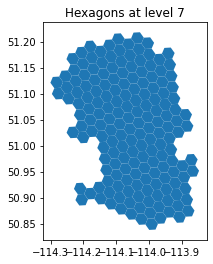

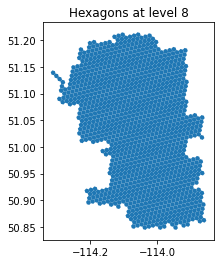

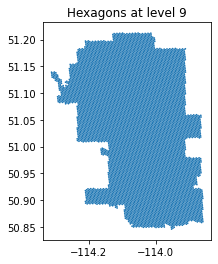

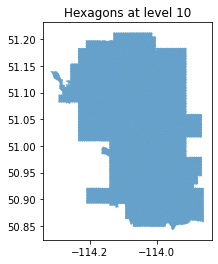

In [18]:
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

sdfs=[]
gdfHexs=[]
for i in range(len(polLists)):
    print(hexDFs[i].attrs)
    gdfHex = geopandas.GeoDataFrame(
    hexDFs[i], geometry=polLists[i], crs="EPSG:4326")
    gdfHexs.append(gdfHex)
    gdfHex.plot()
    plt.title(f"Hexagons at level {hexDFs[i].attrs['resolution']}")
    sdf=GeoAccessor.from_geodataframe(gdfHex)
    sdf.attrs=hexDFs[i].attrs
    sdfs.append(sdf)

We can then upload the Hexagons SDFs to ArcGIS Online and publish them as Feature Layers. We need to first log in into our ArcGIS Online account:

In [19]:
from arcgis.gis import GIS
    
# connect as an anonymous user
gis = GIS("https://ucalgary.maps.arcgis.com", username="mingke.li_ucalgary")

user = gis.users.get('mingke.li_ucalgary')

Enter password: ········


Using our GIS object, we can import the SDFs into ArcGIS Online.

In [20]:
for sdf in sdfs:
    print(f"Uploading hexagons at level {sdf.attrs['resolution']}")
    gis.content.import_data(df=sdf, title=f"Hexagons{sdf.attrs['resolution']}", folder="data")
    print(f"Done with hexagons at level {sdf.attrs['resolution']}")

Uploading hexagons at level 7
Done with hexagons at level 7
Uploading hexagons at level 8
Done with hexagons at level 8
Uploading hexagons at level 9
Done with hexagons at level 9
Uploading hexagons at level 10
Done with hexagons at level 10


## Introduction to Spatially Enabled Dataframes

We present an introduction to [Spatially Enabled Dataframes](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/) as reference. In this section, we are going to use [pandas](https://pandas.pydata.org/), [arcgis.feature module](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#:~:text=represented%20as%20features.-,The%20arcgis.,can%20be%20represented%20as%20features.) and [arcgis.gis module](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html).

###  Reading wards Feature class from file

We will first read the ward polygons dataset from a Shapefile stored in a system folder.

In [20]:
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

data = './data/vector/Census_by_ward_final.shp'

sdf = pd.DataFrame.spatial.from_featureclass(data)

We can check what data is contained in the Shapefile:

In [21]:
sdf.head()

,index,Ward,Resident,Male,Female,Dwelling,Household,Employed,Pre_school,Ownership,...,Refugees,Other,Top1_Count,Top2_Count,Top3_Count,Top4_Count,Top5_Count,Avg_income,SHAPE,OBJECTID
0,0,WARD 11,82636.0,40280.0,42356.0,36800.0,45465.0,42125.0,5902,22800.0,...,2055.0,190,Philippines,United Kingdom,China,United States,India,73171.8,"{""rings"": [[[-114.11815449933067, 51.023899160...",0
1,1,WARD 9,76533.0,38922.0,37611.0,37174.0,37490.0,41935.0,5934,20182.0,...,5200.0,155,Philippines,Viet Nam,United Kingdom,China,Ethiopia,45782.0,"{""rings"": [[[-114.04828320810356, 51.084967480...",1
2,2,WARD 2,94011.0,47052.0,46959.0,32970.0,27355.0,47733.0,8566,26941.0,...,2545.0,330,China,India,Philippines,Hong Kong,Pakistan,46090.8,"{""rings"": [[[-114.09457382562152, 51.197010129...",2
3,3,WARD 1,87565.0,43306.0,44259.0,34063.0,33570.0,42282.0,6628,24113.0,...,1435.0,145,China,United Kingdom,Philippines,India,United States,61786.0,"{""rings"": [[[-114.2486183805338, 51.1542194521...",3
4,4,WARD 8,86454.0,44482.0,41972.0,54490.0,43975.0,55614.0,5474,17755.0,...,3430.0,115,Philippines,United Kingdom,China,India,Ethiopia,64864.7,"{""rings"": [[[-114.17248939696805, 51.069554937...",4


### Interacting with Spatially Enabled Dataframes

We can interact with a Spatially Enabled Dataframe, as if they were [Pandas Dataframes](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html). SDFs just insert a custom namespace called spatial into the Pandas DataFrame structure to give it spatial abilities. 

In [22]:
sdf[['Immigrant', 'SHAPE']].head()

,Immigrant,SHAPE
0,16630.0,"{""rings"": [[[-114.11815449933067, 51.023899160..."
1,20590.0,"{""rings"": [[[-114.04828320810356, 51.084967480..."
2,28135.0,"{""rings"": [[[-114.09457382562152, 51.197010129..."
3,17535.0,"{""rings"": [[[-114.2486183805338, 51.1542194521..."
4,17965.0,"{""rings"": [[[-114.17248939696805, 51.069554937..."


We can plot the SDF into a map. In order to do this, we need to use the [GIS module](https://developers.arcgis.com/python/guide/the-gis-module/) from ArcGIS.

In [23]:
from arcgis.gis import GIS

m1 = GIS().map("Calgary")
m1

MapView(layout=Layout(height='400px', width='100%'))

We can check the Coordinate Reference System of our dataset before plotting:

In [24]:
sdf.spatial.sr

{'wkid': 4326}

We can now generate a map visualization of the dataset, based on the Immigrant Column.

In [25]:
sdf.spatial.plot(map_widget=m1,
               renderer_type='c',  # for class breaks renderer
               method='esriClassifyNaturalBreaks',  # classification algorithm
               class_count=20,  # choose the number of classes
               col='Immigrant',  # numeric column to classify
               cmap='prism',  # color map to pick colors from for each class
               alpha=0.7  # specify opacity
               )

True

After running the previous cell, you will be able to see the dataset on the map.

In [26]:
m1

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

SDFs provide [multiple ways to visualize and interact with data](https://developers.arcgis.com/python/guide/visualizing-data-with-the-spatially-enabled-dataframe/). You can create class breaks or generate histograms. Check the following code for reference.

In [27]:
class_breaks = m1.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos

cbs_list = []
cmap_list = []
for cb in class_breaks:
    print(cb.description)  # print the class break labels
    cbs_list.append(cb.classMaxValue)
    cmap_list.append([x/255.0 for x in cb.symbol.color])

10835.0 - 12708.421052631578
12708.421052631578 - 14581.842105263158
14581.842105263158 - 16455.263157894737
16455.263157894737 - 18328.684210526317
18328.684210526317 - 20202.105263157893
20202.105263157893 - 22075.526315789473
22075.526315789473 - 23948.947368421053
23948.947368421053 - 25822.368421052633
25822.368421052633 - 27695.78947368421
27695.78947368421 - 29569.21052631579
29569.21052631579 - 31442.63157894737
31442.63157894737 - 33316.05263157895
33316.05263157895 - 35189.47368421053
35189.47368421053 - 37062.89473684211
37062.89473684211 - 38936.31578947368
38936.31578947368 - 40809.73684210527
40809.73684210527 - 42683.15789473684
42683.15789473684 - 44556.57894736842
44556.57894736842 - 46430.0
46430.0 - 46430.0


Text(0.5, 1.0, 'Histogram of Inmigrant column')

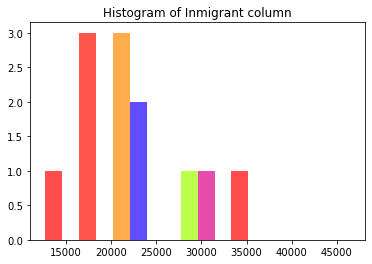

In [28]:
import matplotlib.pyplot as plt
# build a histogram for the same class breaks
n, bins, patches = plt.hist(sdf['Immigrant'], bins=cbs_list)

# apply the same color for each class to match the map
idx = 0
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cmap_list[idx])
    idx+=1

plt.title('Histogram of Inmigrant column')

### Exporting Spatially Enabled Dataframes

#### To Feature Class

You can export a Spatially Enabled Dataframe into a Shapefile. This will generated a file in your system.

In [29]:
fclass=sdf.spatial.to_featureclass("./data/vector/census_by_ward")

#### To Feature Layer

You can also publish this data to a Feature Layer in your ArcGIS account. In order to perform this step, you will need an ArcGIS online account and credentials. We used our own account:

In [30]:
from arcgis.gis import GIS
    
# connect as an anonymous user
gis = GIS("https://ucalgary.maps.arcgis.com", username="mingke.li_ucalgary")

user = gis.users.get('mingke.li_ucalgary')

Enter password: ········


Now we can import data from the SDF. You can give it a title and indicate the folder were you want to publish the feature layer.

In [31]:
item = gis.content.import_data(df=sdf, title="Cesus", folder="data")

In [32]:
item

<Item title:"Cesus" type:Feature Layer Collection owner:mingke.li_ucalgary>

You can now interact with this Item in the notebook. For example, the feature layers are contained within the layers attribute of the item.

In [33]:
print(item.layers[0])

<FeatureLayer url:"https://services2.arcgis.com/XSv3KNGfmrd1txPN/arcgis/rest/services/ad91f9/FeatureServer/0">
